In [1]:
### total flow plots ###
### DTT, 10/22

# This script is split into two main parts: 1) reading in CONUS2 gridded total (aggregated) daily flow for the full domain and creating a dataframe of CONUS2 flow for cells that have been matched with USGS gages in the `NWM_Gage_Adjustments_final.csv`. 2) matching the gages that both have flow between the PF csv and USGS csv retrieved from hydrodata. 
# Note that flow is converted in this script from daily accumulated flow in [m^3/h] to daily mean flow in cms or [m^3/s].

### Inputs:
# - `NWM_Gage_Adjustments_final.csv` - this can be found on the CONUS2 Dropbox or in /glade/p/univ/ucsm0002/CONUS2/domain_files
# - Daily total streamflow PFCLM outputs as PFBs - processed using `compute_daily_PF_averages.py`
# - USGS daily flow csv - from the hydrodata repository on Verde

### Outputs:
# - CSV of PFCLM daily mean flow (cms) with gage ID, lat/long, and CONUS2 cell location
# - two flow-matched CSVs for PF and USGS flow
# - note that the CSV outputs with 'day 001' which starts at the water year (001 == October 1)***

# Notes:
# - need to fix the no_days, currently this will only be accurate if this is started at the begninning of a water year and need to add in some dictionary or if statement to specify num days in a month or something like that.
# - ***need to change day headings so that they are more descriptive than 'day 001' and have an actual date

import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# need to change water year and number of days
water_year = 2003
no_days = 365 

# Directory where PF flow csv's are saved
#directory_out = '/hydrodata/temp/CONUS2_transfers/CONUS2_spinup_WY2003/averages'#'/glade/scratch/tijerina/CONUS2/spinup_WY2003/averages'
organized_dir =  './Organized_Daily_Flow'#'/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Organized_Daily_Flow'
plot_dir = './Figures'#'/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Figures'

# names of csv files
usgs_csv = 'USGS_Daily_matched_flow_cms_2003.csv'
pf_csv = 'PFCONUS2_Daily_matched_flow_cms_2003.csv'
metadata_csv = 'USGS_metadata_matched_flow_2003.csv'




# Average Flow Comparison

In [2]:
usgs_daily_flow = pd.read_csv(f'{organized_dir}/{usgs_csv}',index_col=['site_id'])
CONUS2_daily_flow = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
#CONUS2_daily_flow = CONUS2_daily_flow.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
metadata_df = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])

usgs_daily_flow.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,7.414600,7.386300,6.990100,6.565600,6.36750,6.19770,5.744900,5.065700,4.528000,4.414800,...,12.650100,12.367100,11.942600,12.70670,13.697200,13.612300,13.159500,14.008500,66.2220,76.127000
1013500,3.509200,3.424300,3.169600,3.113000,3.33940,2.85830,2.858300,2.631900,2.405500,2.504550,...,14.376400,13.810400,13.612300,13.55570,13.159500,12.253900,11.942600,15.763100,58.2980,51.223000
1015800,6.707100,6.226000,5.716600,5.377000,5.15060,5.03740,4.754400,4.499700,4.160100,4.188400,...,3.763900,3.650700,3.537500,3.59410,3.735600,3.792200,3.707300,4.216700,25.4134,60.845000
1017000,9.876700,9.367300,8.461700,7.952300,7.81080,7.13160,7.046700,6.678800,6.282600,6.282600,...,7.075000,6.905200,6.792000,6.82030,6.820300,6.848600,6.763700,7.895700,50.6570,147.726000
1017550,0.023772,0.024338,0.020659,0.018395,0.01981,0.01981,0.018678,0.018678,0.018961,0.021791,...,0.080655,0.043016,0.049525,0.07358,0.053204,0.026319,0.023206,0.063675,0.1132,0.105559


In [3]:
CONUS2_daily_flow.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,37.266464,34.151593,31.949418,28.746042,24.794453,21.037749,17.725660,14.927488,12.823219,11.328315,...,0.383030,0.248542,0.270354,0.370566,0.447849,0.437744,0.346303,1.857882,32.173826,0.0
1013500,18.686342,17.994405,17.171830,14.470901,14.358695,12.452931,11.061765,10.040905,9.119768,8.499280,...,0.542694,0.269608,0.231789,0.451696,0.321280,0.249696,0.204132,1.203276,30.743592,0.0
1015800,30.468728,29.614383,27.459663,24.822553,22.551353,19.456863,16.647201,14.524086,12.689513,11.405875,...,0.397749,0.306602,0.316849,0.505316,0.353142,0.297726,0.204833,0.469169,6.413734,0.0
1017000,64.752051,64.284799,62.117018,57.702024,52.771326,48.076338,43.703179,39.512687,35.268489,31.090277,...,1.916867,1.738682,1.658574,1.623249,1.463889,1.393643,1.341100,1.439029,3.284965,0.0
1017550,0.044492,0.028687,0.010159,0.003003,0.004380,0.001411,0.000000,0.000000,0.000000,0.000036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [4]:
metadata_df.columns

Index(['site_type', 'agency', 'site_name', 'site_id_agency', 'site_query_url',
       'date_metadata_last_updated', 'latitude', 'longitude', 'state', 'huc',
       'tz_cd', 'observation_id', 'site_id:1', 'var_id', 'start_date_listed',
       'end_date_listed', 'is_current', 'is_series',
       'first_date_data_available', 'last_date_data_available', 'record_count',
       'date_verified_through', 'latest_download_date', 'file_path',
       'conus1_x', 'conus1_y', 'conus1_latitude', 'conus1_longitude',
       'conus1_moved', 'conus1_parflow_drainage_area', 'conus2_x', 'conus2_y',
       'conus2_latitude', 'conus2_longitude', 'conus2_moved',
       'conus2_parflow_drainage_area', 'gages_drainage_sqkm', 'bound_source',
       'class', 'aggecoregion', 'hydro_disturb_indx', 'wr_report_remarks',
       'adr_citation', 'screening_comments', 'basin_compactness',
       'basin_elevation_mean_meters', 'basin_elevation_max_meters',
       'basin_elevation_min_meters', 'basin_elevation_median_mete

In [5]:
metadata_df

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,local_time_fg,reliability_cd,project_no,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,stream gauge,USGS,"Allagash River near Allagash, Maine",1011000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.069722,-69.079444,ME,1010002,...,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1478.00,1229.00,Y,NaN,442300100.0,365
1013500,stream gauge,USGS,"Fish River near Fort Kent, Maine",1013500,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.237500,-68.582778,ME,1010003,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,873.00,873.00,Y,NaN,442300100.0,365
1015800,stream gauge,USGS,"Aroostook River near Masardis, Maine",1015800,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.523056,-68.371667,ME,1010004,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,892.00,892.00,Y,NaN,442300100.0,365
1017000,stream gauge,USGS,"Aroostook River at Washburn, Maine",1017000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.777222,-68.157222,ME,1010004,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1654.00,1654.00,Y,NaN,442300100.0,365
1017550,stream gauge,USGS,"Williams Brook at Phair, Maine",1017550,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.628056,-67.953056,ME,1010005,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,3.82,3.82,Y,NaN,442300100.0,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14366000,stream gauge,USGS,"APPLEGATE RIVER NEAR APPLEGATE, OR",14366000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,42.241511,-123.140049,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,483.00,NaN,Y,C,NaN,365
14369500,stream gauge,USGS,"APPLEGATE RIVER NEAR WILDERVILLE, OR",14369500,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,42.354006,-123.406728,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,698.00,NaN,Y,C,NaN,365
14372300,stream gauge,USGS,"ROGUE RIVER NEAR AGNESS, OR",14372300,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,42.578442,-124.058144,OR,17100310,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,3939.00,NaN,Y,C,NaN,365


### Calculate mean flows

In [6]:
usgs_daily_flow['usgs total flow'] = usgs_daily_flow.sum(axis=1)
usgs_daily_flow['daily mean'] = usgs_daily_flow.sum(axis=1)/no_days
#usgs_daily_flow['monthly total (log)'] = np.log10(usgs_daily_flow.sum(axis=1)) # DONT HAVE TO DO THIS HERE BECAUSE YOU CAN SET THE PLOT AXIS
# #usgs_daily_flow['daily mean log'] = np.log10(usgs_daily_flow['daily mean'])

In [7]:
usgs_daily_flow.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30,usgs total flow,daily mean
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,7.414600,7.386300,6.990100,6.565600,6.36750,6.19770,5.744900,5.065700,4.528000,4.414800,...,11.942600,12.70670,13.697200,13.612300,13.159500,14.008500,66.2220,76.127000,15270.340400,83.673098
1013500,3.509200,3.424300,3.169600,3.113000,3.33940,2.85830,2.858300,2.631900,2.405500,2.504550,...,13.612300,13.55570,13.159500,12.253900,11.942600,15.763100,58.2980,51.223000,14383.027860,78.811112
1015800,6.707100,6.226000,5.716600,5.377000,5.15060,5.03740,4.754400,4.499700,4.160100,4.188400,...,3.537500,3.59410,3.735600,3.792200,3.707300,4.216700,25.4134,60.845000,12261.456100,67.186061
1017000,9.876700,9.367300,8.461700,7.952300,7.81080,7.13160,7.046700,6.678800,6.282600,6.282600,...,6.792000,6.82030,6.820300,6.848600,6.763700,7.895700,50.6570,147.726000,24401.816500,133.708584
1017550,0.023772,0.024338,0.020659,0.018395,0.01981,0.01981,0.018678,0.018678,0.018961,0.021791,...,0.049525,0.07358,0.053204,0.026319,0.023206,0.063675,0.1132,0.105559,52.182936,0.285934


In [10]:
usgs_daily_flow = usgs_daily_flow.where(usgs_daily_flow>0, 0.0001)

In [11]:
CONUS2_daily_flow['pf total flow'] = CONUS2_daily_flow.sum(axis=1)
CONUS2_daily_flow['daily mean'] = CONUS2_daily_flow.sum(axis=1)/no_days
#CONUS2_daily_flow['monthly total (log)'] = np.log10(CONUS2_daily_flow.sum(axis=1))  # DONT HAVE TO DO THIS HERE BECAUSE YOU CAN SET THE PLOT AXIS
#CONUS2_daily_flow['daily mean log'] = np.log10(CONUS2_daily_flow['daily mean'])

In [12]:
CONUS2_daily_flow.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30,pf total flow,daily mean
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,37.266464,34.151593,31.949418,28.746042,24.794453,21.037749,17.725660,14.927488,12.823219,11.328315,...,0.270354,0.370566,0.447849,0.437744,0.346303,1.857882,32.173826,0.0,10845.724857,59.428629
1013500,18.686342,17.994405,17.171830,14.470901,14.358695,12.452931,11.061765,10.040905,9.119768,8.499280,...,0.231789,0.451696,0.321280,0.249696,0.204132,1.203276,30.743592,0.0,6791.693043,37.214756
1015800,30.468728,29.614383,27.459663,24.822553,22.551353,19.456863,16.647201,14.524086,12.689513,11.405875,...,0.316849,0.505316,0.353142,0.297726,0.204833,0.469169,6.413734,0.0,9891.834677,54.201834
1017000,64.752051,64.284799,62.117018,57.702024,52.771326,48.076338,43.703179,39.512687,35.268489,31.090277,...,1.658574,1.623249,1.463889,1.393643,1.341100,1.439029,3.284965,0.0,21244.849284,116.410133
1017550,0.044492,0.028687,0.010159,0.003003,0.004380,0.001411,0.000000,0.000000,0.000000,0.000036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,23.039649,0.126245


In [13]:
# R^2 computations
r2_daily_mean = r2_score(usgs_daily_flow['daily mean'], CONUS2_daily_flow['daily mean'])
#r2_month_total = r2_score(usgs_daily_flow['monthly total (log)'], CONUS2_daily_flow['monthly total (log)'])
r2_daily_mean

0.6675080461761872

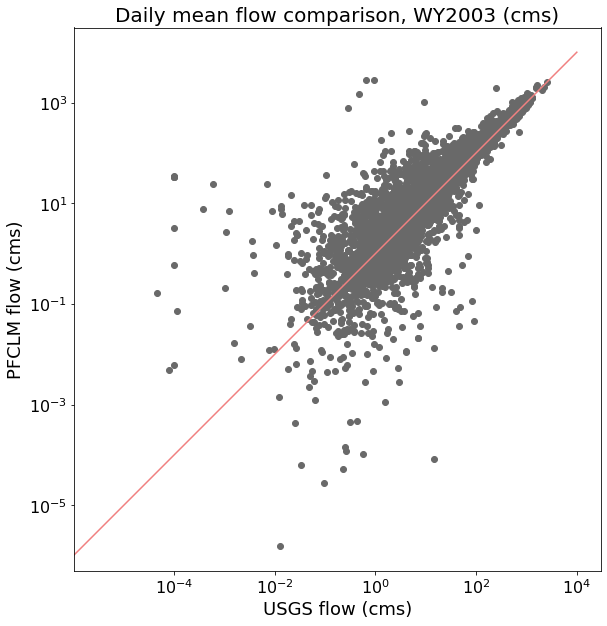

In [14]:
# Scatter plot of daily mean flow for October WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(usgs_daily_flow['daily mean'], CONUS2_daily_flow['daily mean'], color = 'dimgrey')
ax.plot(range(10000), color = 'lightcoral')
plt.ylabel('PFCLM flow (cms)',fontsize=18)
plt.xlabel('USGS flow (cms)',fontsize=18)
plt.title('Daily mean flow comparison, WY2003 (cms)',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'{plot_dir}/WY2003_daily_mean_flow_comparison_scatter.png')




### NOT SURE THE PLOT BELOW MAKES SENSE

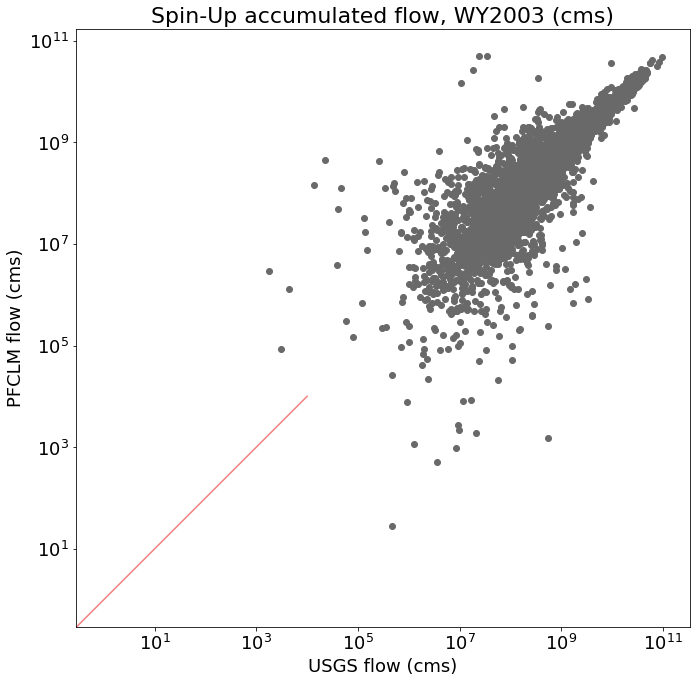

In [21]:
# Scatter plot of monthly total flow for October WY2003, PF vs. USGS
fig = plt.figure(figsize=(11,11), dpi=72)
ax = fig.add_subplot()

ax.scatter(usgs_daily_flow['usgs total flow']*100000, CONUS2_daily_flow['pf total flow']*100000, color = 'dimgrey')
# square plot
ax.set_aspect('equal', adjustable='box')
ax.plot(range(10000), color = 'lightcoral')
plt.ylabel('PFCLM flow (cms)',fontsize=18)
plt.xlabel('USGS flow (cms)',fontsize=18)
plt.title('Spin-Up accumulated flow, WY2003 (cms)',fontsize=22)
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

plt.savefig(f'{plot_dir}/WY2003_total_monthly_flow_log_comparison_scatter.png')

/glade/work/tijerina/conda-envs/parflow-npl/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


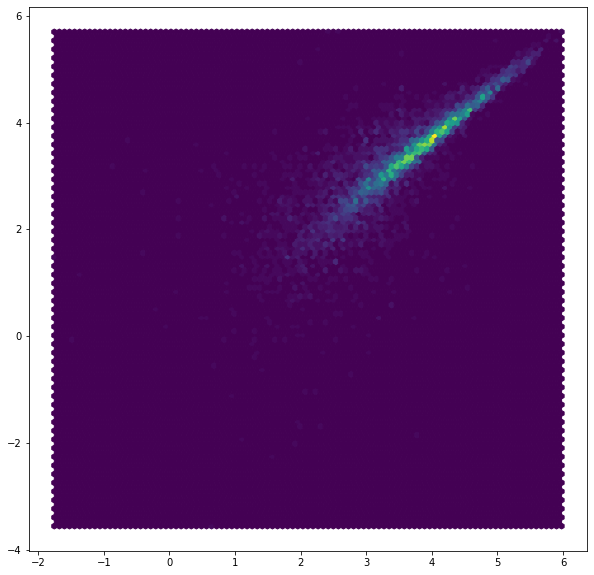

In [22]:

# Scatter plot of daily mean flow for October WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()
ax.hexbin(np.log10(usgs_daily_flow['usgs total flow']), np.log10(CONUS2_daily_flow['pf total flow']))
ax.plot(range(1), color = 'lightcoral')

ValueError: x contains non-positive values, so can not be log-scaled

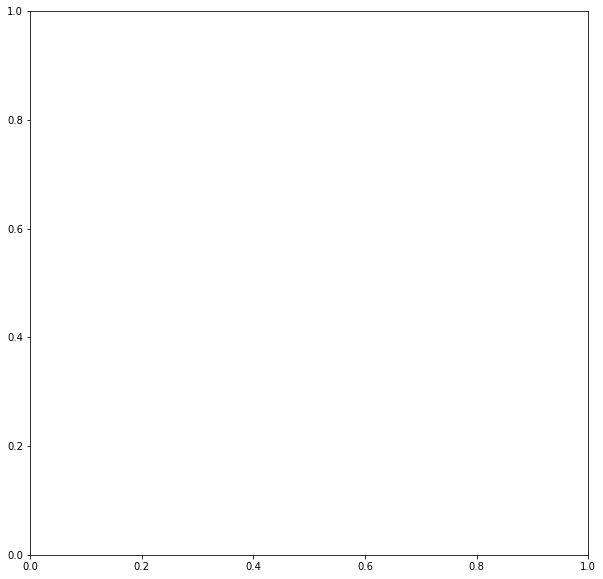

In [16]:
# Scatter plot of daily mean flow for October WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()
ax.hexbin(usgs_daily_flow['usgs total flow'], CONUS2_daily_flow['pf total flow'],xscale='log')
ax.plot(range(100), color = 'lightcoral')

In [17]:
CONUS2_daily_flow['pf total flow'].max()

48648.23452870347

In [18]:
CONUS2_daily_flow['monthly total (log)'].min()

KeyError: 'monthly total (log)'

In [ ]:
usgs_daily_flow['monthly total (log)'].min()

In [19]:
#df["A"].str[:-1]

metadata_df['HUC2'] = metadata_df['huc'].astype(str).str[:-6]
metadata_df['HUC2']

site_id
1011000      1
1013500      1
1015800      1
1017000      1
1017550      1
            ..
242354750    3
344894205    6
351706800    6
422026250    4
423205010    4
Name: HUC2, Length: 4999, dtype: object

In [20]:
# Scatter plot of daily mean flow for October WY2003, PF vs. USGS

plot_df = pd.DataFrame().assign(CONUS_mean = CONUS2_daily_flow['daily mean'],USGS_mean = usgs_daily_flow['daily mean'], HUC2 = metadata_df['HUC2'])
groups = plot_df.groupby('HUC2')
groups


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


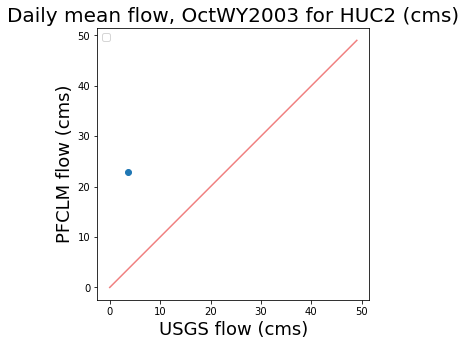

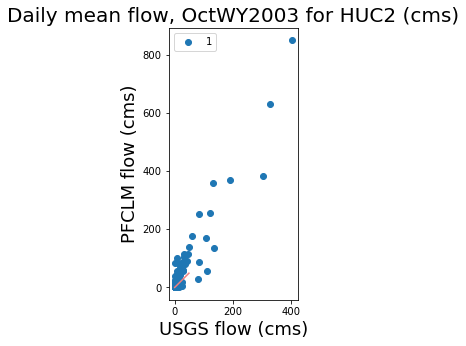

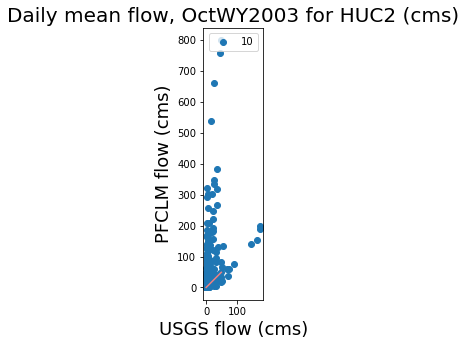

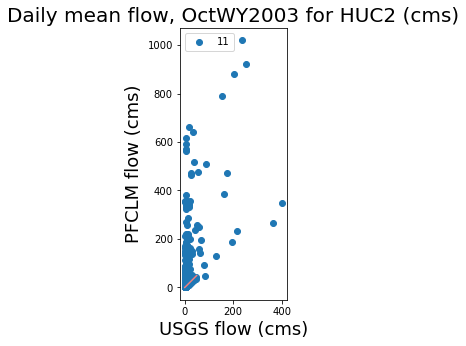

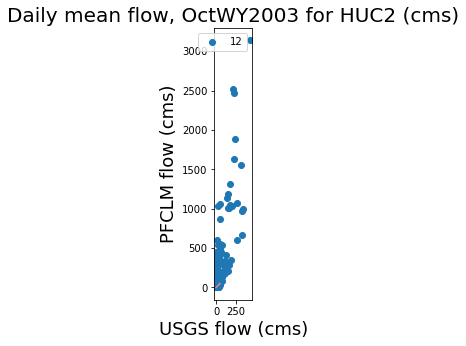

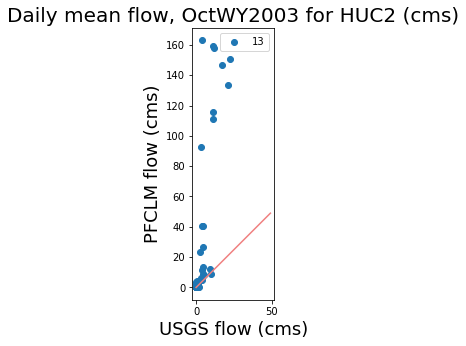

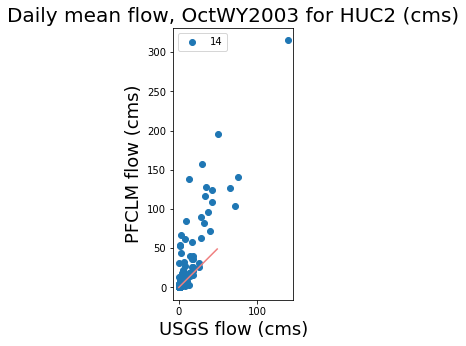

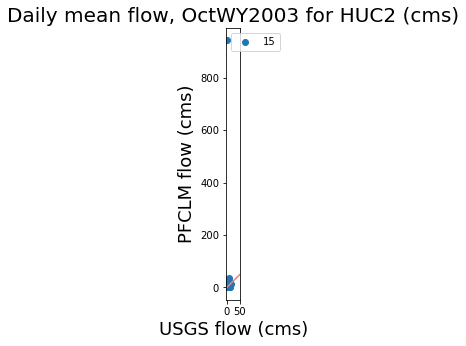

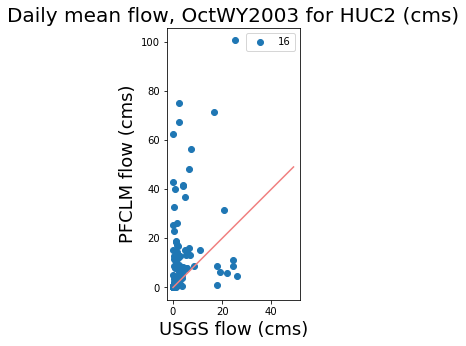

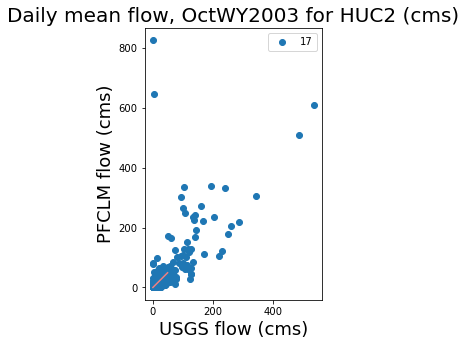

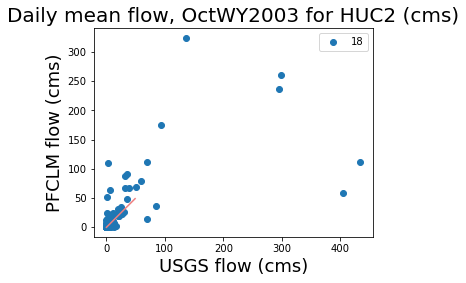

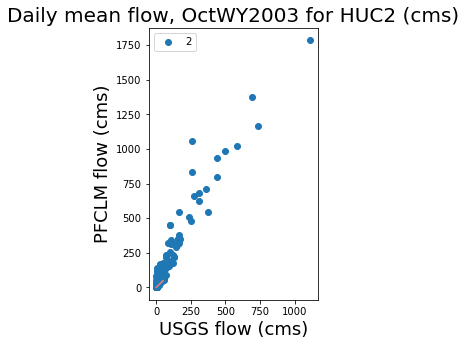

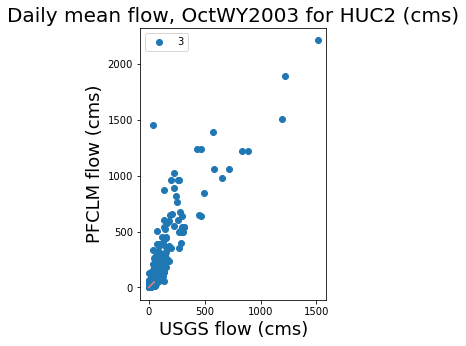

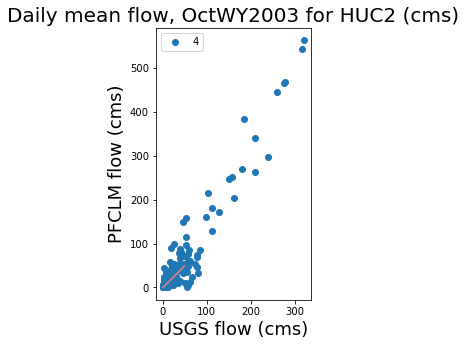

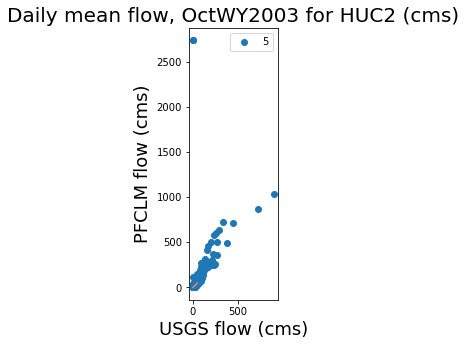

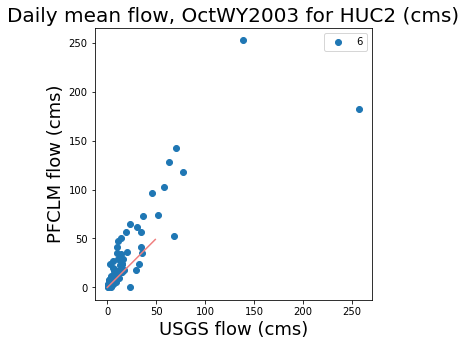

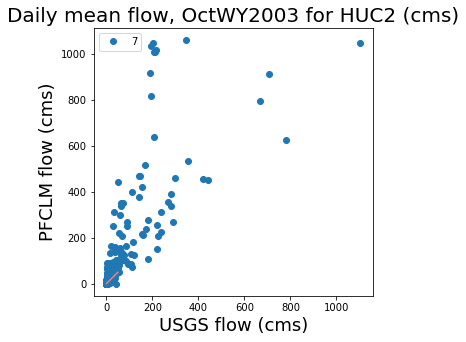

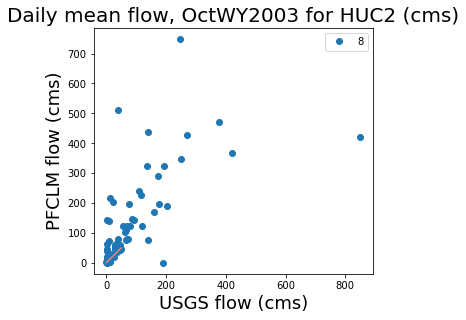

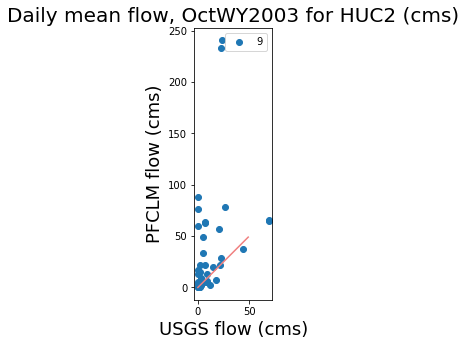

In [21]:

for name, group in groups:
    fig = plt.figure(figsize=(5,5), dpi=72)
    ax = fig.add_subplot()
    ax.plot(group.USGS_mean,group.CONUS_mean, marker='o', linestyle='', label=name)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.plot(range(50), color = 'lightcoral')
    plt.ylabel('PFCLM flow (cms)',fontsize=18)
    plt.xlabel('USGS flow (cms)',fontsize=18)
    plt.title(f'Daily mean flow, OctWY2003 for HUC2 (cms)',fontsize=20)
    
    

# ax.scatter(CONUS2_daily_flow['daily mean'],usgs_daily_flow['daily mean'], c = metadata_df['HUC2'], cmap = 'greens')
# ax.plot(range(1000), color = 'lightcoral')
# plt.xlabel('PFCLM flow (cms)',fontsize=18)
# plt.ylabel('USGS flow (cms)',fontsize=18)
# plt.title('Daily mean flow comparison, October WY2003 (cms)',fontsize=20)
# ax.xaxis.set_tick_params(labelsize=16)
# ax.yaxis.set_tick_params(labelsize=16)
# # square plot
# ax.set_aspect('equal', adjustable='box')
# #plt.savefig(f'{plot_dir}/Oct_WY2003_daily_mean_flow_comparison_scatter.png')

In [22]:
huc_2_names = {1:'New England', 2:'Mid-Atlantic', 3:'South Atlantic-Gulf', 4:'Great Lakes',
              5:'Ohio', 6:'Tennessee', 7:'Upper Miss', 8:'Lower Miss', 9:'Souris-Red-Rainy',
              10: 'Missouri', 11: 'Ar-White-Red', 12: 'Texas', 13: 'Rio Grande', 
              14: 'Upper CO', 15: 'Lower CO', 16: 'Great Basin', 17: 'Pacific Northwest',
              18: 'California'}

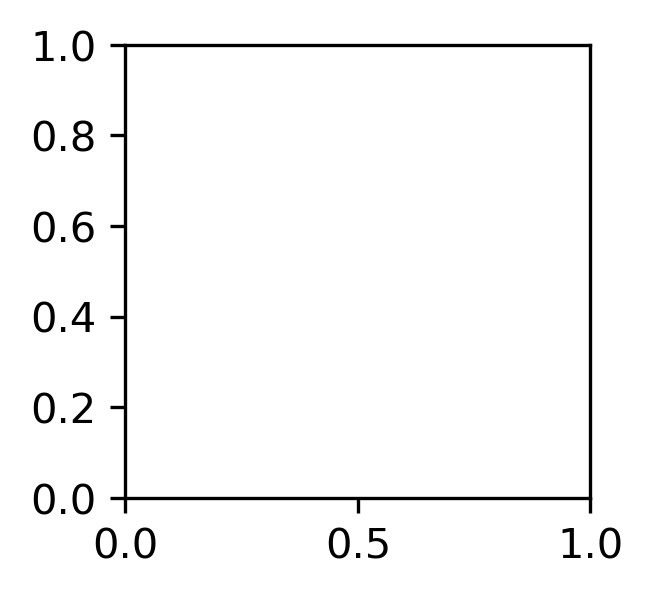

In [23]:
fig = plt.figure(figsize=(2,2), dpi=300)
ax = fig.add_subplot()

In [ ]:
plt.scatter(CONUS2_daily_flow['daily mean log'],usgs_daily_flow['daily mean log'])
plt.xlabel('pf flow')
plt.ylabel('usgs flow')